# <center>Data 266 - Lab 1 - Part 3</center>
<p style="text-align: right;">Shao-Yu Huang 018195554<p>
<p style="text-align: right;">Akshit Tyagi <p>

## Image Style Transfer using Generative Adversarial Network (GAN)

## 3.1 Model Implementation and Training
1. Prepare two unpaired image domains from the dataset.
2. Implement a CycleGAN architecture, consisting of:
    - Two generators
    - Two discriminators
3. Train the model using:
    - Adversarial loss
    - Cycle-consistency loss
4. Perform image translation between the two domains.
5. Analyse training behaviour, including convergence and stability.

### Imports, seed, device, config, paths

In [30]:
import os
import glob
import random
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

@dataclass
class CFG:
    part3_root: str = "Part 3"
    dataset_root: str = "dataset"
    monet_dir: str = "monet_jpg"
    photo_dir: str = "photo_jpg"

    image_size: int = 256

    batch_size: int = 1
    num_workers: int = 0
    pin_memory: bool = True

    epochs: int = 35

    lr_g: float = 2e-4
    lr_d: float = 4e-4
    betas: Tuple[float, float] = (0.5, 0.999)

    lambda_cyc: float = 10.0

    use_identity: bool = False
    lambda_id: float = 5.0

    pool_size: int = 50

    use_amp: bool = True

    decay_start_epoch: int = 20

    sample_every_steps: int = 500

cfg = CFG()


monet_path = os.path.join(cfg.dataset_root, cfg.monet_dir)
photo_path = os.path.join(cfg.dataset_root, cfg.photo_dir)
assert os.path.isdir(monet_path), f"Missing {monet_path}"
assert os.path.isdir(photo_path), f"Missing {photo_path}"

os.makedirs(cfg.part3_root, exist_ok=True)

print("Monet folder:", monet_path)
print("Photo folder:", photo_path)

Device: cuda
Monet folder: dataset\monet_jpg
Photo folder: dataset\photo_jpg


### Prepare two unpaired domains, dataset, dataloader

In [31]:
def list_images(folder: str) -> List[str]:
    exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
    paths = []
    for ext in exts:
        paths.extend(glob.glob(os.path.join(folder, f"*{ext}")))
    return sorted(list(set(paths)))

train_tfm = T.Compose([
    T.Resize(cfg.image_size + 30),
    T.RandomCrop(cfg.image_size),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_tfm = T.Compose([
    T.Resize(cfg.image_size),
    T.CenterCrop(cfg.image_size),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

class UnpairedImageDataset(Dataset):
    def __init__(self, monet_folder: str, photo_folder: str, tfm: T.Compose):
        self.A = list_images(monet_folder)
        self.B = list_images(photo_folder)
        self.tfm = tfm

    def __len__(self):
        return max(len(self.A), len(self.B))

    def __getitem__(self, idx):
        a_path = self.A[idx % len(self.A)]
        b_path = self.B[random.randint(0, len(self.B) - 1)]

        a = Image.open(a_path).convert("RGB")
        b = Image.open(b_path).convert("RGB")

        return {
            "A": self.tfm(a),  # Monet
            "B": self.tfm(b),  # Photo
        }

train_ds = UnpairedImageDataset(monet_path, photo_path, train_tfm)
train_loader = DataLoader(
    train_ds,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=(cfg.pin_memory and device.type == "cuda"),
)

print("Train length:", len(train_ds))
print("Monet count:", len(train_ds.A))
print("Photo count:", len(train_ds.B))

Train length: 7038
Monet count: 300
Photo count: 7038


### Implement CycleGAN architecture, models

In [32]:
class ResnetBlock(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0, bias=False),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0, bias=False),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, ngf=64, n_blocks=9):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, ngf, 7, 1, 0, bias=False),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
        ]

        cur = ngf
        for _ in range(2):
            layers += [
                nn.Conv2d(cur, cur * 2, 3, 2, 1, bias=False),
                nn.InstanceNorm2d(cur * 2),
                nn.ReLU(True),
            ]
            cur *= 2

        for _ in range(n_blocks):
            layers += [ResnetBlock(cur)]

        for _ in range(2):
            layers += [
                nn.ConvTranspose2d(cur, cur // 2, 3, 2, 1, output_padding=1, bias=False),
                nn.InstanceNorm2d(cur // 2),
                nn.ReLU(True),
            ]
            cur //= 2

        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(cur, out_ch, 7, 1, 0),
            nn.Tanh(),
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=3, ndf=64):
        super().__init__()

        def block(in_c, out_c, stride, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride, 1)]
            if norm:
                layers += [nn.InstanceNorm2d(out_c)]
            layers += [nn.LeakyReLU(0.2, True)]
            return layers

        self.net = nn.Sequential(
            *block(in_ch, ndf, 2, norm=False),
            *block(ndf, ndf * 2, 2),
            *block(ndf * 2, ndf * 4, 2),
            *block(ndf * 4, ndf * 8, 1),
            nn.Conv2d(ndf * 8, 1, 4, 1, 1),
        )

    def forward(self, x):
        return self.net(x)

G_A2B = ResnetGenerator(n_blocks=9).to(device)  # Monet -> Photo
G_B2A = ResnetGenerator(n_blocks=9).to(device)  # Photo -> Monet
D_A = PatchDiscriminator().to(device)            # Monet discriminator
D_B = PatchDiscriminator().to(device)            # Photo discriminator

print("Initialized CycleGAN models")

Initialized CycleGAN models


### Losses, replay buffer, optimizers, AMP, LR schedule

In [33]:
l1 = nn.L1Loss()

def d_ls_loss(pred_real, pred_fake):
    return 0.5 * (torch.mean((pred_real - 1) ** 2) + torch.mean((pred_fake - 0) ** 2))

def g_ls_loss(pred_fake):
    return 0.5 * torch.mean((pred_fake - 1) ** 2)

class ImagePool:
    def __init__(self, size: int):
        self.size = size
        self.images: List[torch.Tensor] = []

    def query(self, images: torch.Tensor) -> torch.Tensor:
        if self.size <= 0:
            return images
        out = []
        for img in images:
            img = img.detach().unsqueeze(0)
            if len(self.images) < self.size:
                self.images.append(img)
                out.append(img)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = img
                    out.append(tmp)
                else:
                    out.append(img)
        return torch.cat(out, dim=0)

pool_A = ImagePool(cfg.pool_size)
pool_B = ImagePool(cfg.pool_size)

opt_G = torch.optim.Adam(
    list(G_A2B.parameters()) + list(G_B2A.parameters()),
    lr=cfg.lr_g,
    betas=cfg.betas,
)
opt_D = torch.optim.Adam(
    list(D_A.parameters()) + list(D_B.parameters()),
    lr=cfg.lr_d,
    betas=cfg.betas,
)

scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))

def set_requires_grad(net: nn.Module, req: bool):
    for p in net.parameters():
        p.requires_grad = req

def update_lr(optimizer, epoch):
    if epoch < cfg.decay_start_epoch:
        return
    total_decay = max(1, cfg.epochs - cfg.decay_start_epoch)
    factor = 1.0 - (epoch - cfg.decay_start_epoch) / total_decay
    for pg in optimizer.param_groups:
        pg["lr"] = pg["lr"] * factor

C:\Users\Sandy\AppData\Local\Temp\ipykernel_6744\3332673063.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))


### Training

In [35]:
log_steps = []
log_G = []
log_D = []
log_adv = []
log_cyc = []
log_id = []

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

global_step = 0
G_A2B.train(); G_B2A.train(); D_A.train(); D_B.train()

if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats()

for epoch in range(cfg.epochs):

    epoch_bar = tqdm(
        train_loader,
        desc=f"Epoch [{epoch+1}/{cfg.epochs}]",
        leave=True
    )

    for batch in epoch_bar:
        try:
            real_A = batch["A"].to(device, non_blocking=True)
            real_B = batch["B"].to(device, non_blocking=True)

            # -----------------
            # Train Generators
            # -----------------
            set_requires_grad(D_A, False)
            set_requires_grad(D_B, False)
            opt_G.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):
                fake_B = G_A2B(real_A)
                fake_A = G_B2A(real_B)

                rec_A = G_B2A(fake_B)
                rec_B = G_A2B(fake_A)

                pred_fake_B = D_B(fake_B)
                pred_fake_A = D_A(fake_A)

                loss_G_adv = g_ls_loss(pred_fake_B) + g_ls_loss(pred_fake_A)
                loss_cycle = l1(rec_A, real_A) + l1(rec_B, real_B)

                loss_G = loss_G_adv + cfg.lambda_cyc * loss_cycle


                # store logs every step
                log_steps.append(global_step)
                log_G.append(loss_G.item())
                log_D.append(loss_D.item())
                log_adv.append(loss_G_adv.item())
                log_cyc.append(loss_cycle.item())
                log_id.append(loss_id.item() if isinstance(loss_id, torch.Tensor) else float(loss_id))

                if cfg.use_identity:
                    idt_A = G_B2A(real_A)
                    idt_B = G_A2B(real_B)
                    loss_id = l1(idt_A, real_A) + l1(idt_B, real_B)
                    loss_G = loss_G + cfg.lambda_id * loss_id
                else:
                    loss_id = torch.tensor(0.0, device=device)

            scaler.scale(loss_G).backward()
            scaler.step(opt_G)
            scaler.update()

            # -----------------
            # Train Discriminators
            # -----------------
            set_requires_grad(D_A, True)
            set_requires_grad(D_B, True)
            opt_D.zero_grad(set_to_none=True)

            fake_A_pool = pool_A.query(fake_A)
            fake_B_pool = pool_B.query(fake_B)

            with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):
                pred_real_A = D_A(real_A)
                pred_fake_Ap = D_A(fake_A_pool)
                loss_D_A = d_ls_loss(pred_real_A, pred_fake_Ap)

                pred_real_B = D_B(real_B)
                pred_fake_Bp = D_B(fake_B_pool)
                loss_D_B = d_ls_loss(pred_real_B, pred_fake_Bp)

                loss_D = loss_D_A + loss_D_B

            scaler.scale(loss_D).backward()
            scaler.step(opt_D)
            scaler.update()

            global_step += 1

            # -----------------
            # Update tqdm bar
            # -----------------
            if device.type == "cuda":
                peak_gb = torch.cuda.max_memory_allocated() / 1024**3
            else:
                peak_gb = 0

            epoch_bar.set_postfix({
                "G": f"{loss_G.item():.3f}",
                "D": f"{loss_D.item():.3f}",
                "cyc": f"{loss_cycle.item():.3f}",
                "peakGB": f"{peak_gb:.2f}"
            })

            # Save debug samples
            if global_step % cfg.sample_every_steps == 0:
                os.makedirs(os.path.join(cfg.part3_root, "debug_samples"), exist_ok=True)
                grid = torch.cat([real_A, fake_B, rec_A, real_B, fake_A, rec_B], dim=0)
                vutils.save_image(
                    denorm(grid),
                    os.path.join(cfg.part3_root, "debug_samples", f"e{epoch+1}_s{global_step}.jpg"),
                    nrow=3
                )

        except torch.cuda.OutOfMemoryError:
            print("CUDA OOM, skipping batch")
            if device.type == "cuda":
                torch.cuda.empty_cache()
            continue

    update_lr(opt_G, epoch)
    update_lr(opt_D, epoch)

save_path = os.path.join(cfg.part3_root, "save_model.pth")
torch.save(
    {
        "G_A2B": G_A2B.state_dict(),
        "G_B2A": G_B2A.state_dict(),
        "D_A": D_A.state_dict(),
        "D_B": D_B.state_dict(),
        "cfg": cfg.__dict__,
        "seed": SEED,
    },
    save_path,
)

print("Saved:", save_path)

Epoch [1/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

C:\Users\Sandy\AppData\Local\Temp\ipykernel_6744\2413095669.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):
C:\Users\Sandy\AppData\Local\Temp\ipykernel_6744\2413095669.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device.type == "cuda")):


Epoch [2/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [3/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [4/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [5/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [6/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [7/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [8/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [9/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [10/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [11/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [12/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [13/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [14/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [15/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [16/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [17/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [18/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [19/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [20/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [21/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [22/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [23/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [24/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [25/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [26/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [27/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [28/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [29/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [30/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [31/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [32/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [33/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [34/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Epoch [35/35]:   0%|          | 0/7038 [00:00<?, ?it/s]

Saved: Part 3\save_model.pth


### Perform image translation, generate required folders

In [36]:
@torch.no_grad()
def translate_folder(generator: nn.Module, in_folder: str, out_folder: str, tfm: T.Compose):
    os.makedirs(out_folder, exist_ok=True)
    paths = list_images(in_folder)
    generator.eval()
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = tfm(img).unsqueeze(0).to(device)
        y = generator(x)
        y = denorm(y.squeeze(0)).cpu()
        out = T.ToPILImage()(y)
        base = os.path.splitext(os.path.basename(p))[0]
        out.save(os.path.join(out_folder, f"{base}.jpg"), quality=95)

ckpt = torch.load(os.path.join(cfg.part3_root, "save_model.pth"), map_location=device)
G_A2B.load_state_dict(ckpt["G_A2B"])
G_B2A.load_state_dict(ckpt["G_B2A"])

monet2photo_dir = os.path.join(cfg.part3_root, "monet2photo")
photo2monet_dir = os.path.join(cfg.part3_root, "photo2monet")

translate_folder(G_A2B, monet_path, monet2photo_dir, test_tfm)
translate_folder(G_B2A, photo_path, photo2monet_dir, test_tfm)

print("Generated folders:")
print(monet2photo_dir)
print(photo2monet_dir)

pred_A2B = os.path.join(cfg.part3_root, "pred_A2B")
pred_B2A = os.path.join(cfg.part3_root, "pred_B2A")

translate_folder(G_A2B, monet_path, pred_A2B, test_tfm)
translate_folder(G_B2A, photo_path, pred_B2A, test_tfm)

print("Also generated for evaluation notebook defaults:")
print(pred_A2B)
print(pred_B2A)

C:\Users\Sandy\AppData\Local\Temp\ipykernel_6744\1813602179.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(cfg.part3_root, "save_model.p

Generated folders:
Part 3\monet2photo
Part 3\photo2monet
Also generated for evaluation notebook defaults:
Part 3\pred_A2B
Part 3\pred_B2A


## 3.2 Evaluation and Analysis
1. Visual quality of translated images.
2. Correct implementation of cycle-consistency constraints.
3. Training stability and loss behaviour.
4. Quality of analysis, observations, and discussion of shortcomings

In [37]:
import scipy.linalg
from scipy.spatial.distance import cosine
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt

### Visual quality, save a comparison grid for the report

In [38]:
os.makedirs(os.path.join(cfg.part3_root, "report_grids"), exist_ok=True)

batch = next(iter(train_loader))
real_A = batch["A"].to(device)
real_B = batch["B"].to(device)

with torch.no_grad():
    fake_B = G_A2B(real_A)
    rec_A = G_B2A(fake_B)

    fake_A = G_B2A(real_B)
    rec_B = G_A2B(fake_A)

grid = torch.cat([real_A, fake_B, rec_A, real_B, fake_A, rec_B], dim=0)
out_path = os.path.join(cfg.part3_root, "report_grids", "qualitative_grid.jpg")
vutils.save_image(denorm(grid), out_path, nrow=3)
print("Saved qualitative grid:", out_path)

Saved qualitative grid: Part 3\report_grids\qualitative_grid.jpg


### Check cycle consistency numerically, report L1 reconstruction

In [39]:
with torch.no_grad():
    cyc_A_l1 = torch.mean(torch.abs(rec_A - real_A)).item()
    cyc_B_l1 = torch.mean(torch.abs(rec_B - real_B)).item()

print("Cycle L1 Monet recon:", cyc_A_l1)
print("Cycle L1 Photo recon:", cyc_B_l1)

Cycle L1 Monet recon: 0.06632667779922485
Cycle L1 Photo recon: 0.05317539721727371


### Training stability and loss behavior

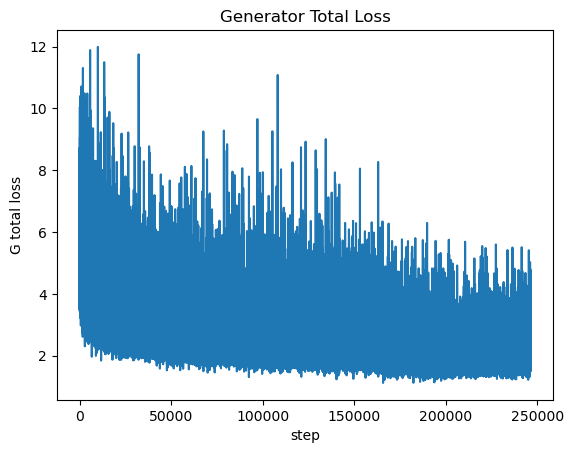

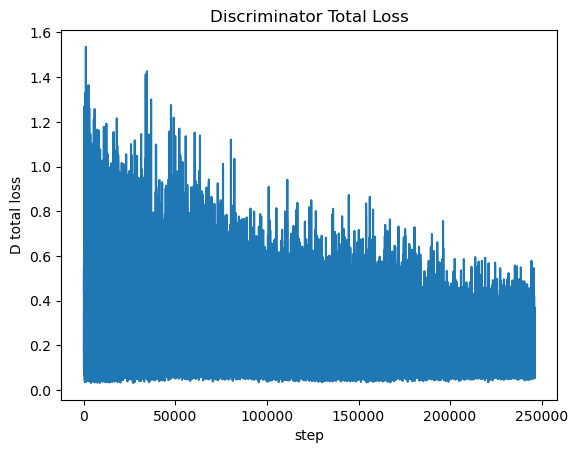

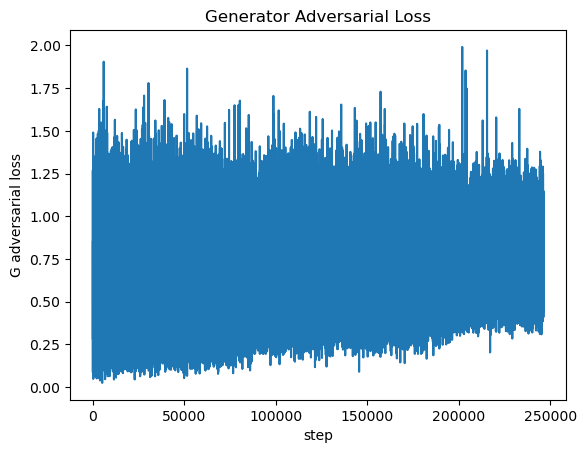

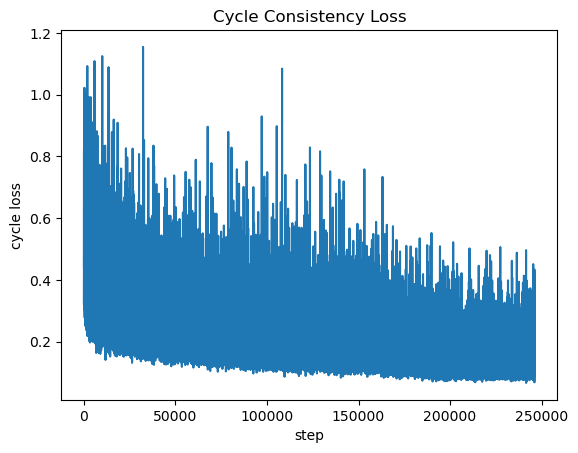

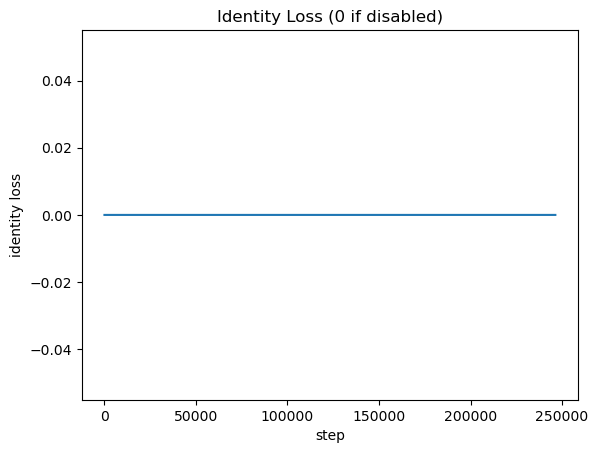

In [40]:
plt.figure()
plt.plot(log_steps, log_G)
plt.xlabel("step")
plt.ylabel("G total loss")
plt.title("Generator Total Loss")
plt.show()

plt.figure()
plt.plot(log_steps, log_D)
plt.xlabel("step")
plt.ylabel("D total loss")
plt.title("Discriminator Total Loss")
plt.show()

plt.figure()
plt.plot(log_steps, log_adv)
plt.xlabel("step")
plt.ylabel("G adversarial loss")
plt.title("Generator Adversarial Loss")
plt.show()

plt.figure()
plt.plot(log_steps, log_cyc)
plt.xlabel("step")
plt.ylabel("cycle loss")
plt.title("Cycle Consistency Loss")
plt.show()

plt.figure()
plt.plot(log_steps, log_id)
plt.xlabel("step")
plt.ylabel("identity loss")
plt.title("Identity Loss (0 if disabled)")
plt.show()

### Compute FID and MiFID

In [ ]:
INCEPTION_TF = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def get_inception_model():
    inception = models.inception_v3(
        weights=models.Inception_V3_Weights.IMAGENET1K_V1,
        transform_input=False
    )
    inception.fc = nn.Identity()
    inception.to(device)
    inception.eval()
    return inception

def take_n(paths, n):
    return paths[:min(n, len(paths))]

def load_batch(paths):
    imgs = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        imgs.append(INCEPTION_TF(img))
    return torch.stack(imgs, dim=0)

@torch.no_grad()
def get_activations(model, image_paths, batch_size=32):
    feats = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        x = load_batch(batch_paths).to(device)
        y = model(x).detach().cpu().numpy()
        feats.append(y)
    return np.concatenate(feats, axis=0)

def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = scipy.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    diff = mu1 - mu2
    return float(diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean))

def calculate_fid_mifid(real_paths, gen_paths, batch_size=32):
    real_paths = sorted(real_paths)
    gen_paths = sorted(gen_paths)

    n = min(len(real_paths), len(gen_paths))
    real_paths = real_paths[:n]
    gen_paths = gen_paths[:n]

    model = get_inception_model()
    real_act = get_activations(model, real_paths, batch_size=batch_size)
    gen_act = get_activations(model, gen_paths, batch_size=batch_size)

    mu_r, sig_r = real_act.mean(axis=0), np.cov(real_act, rowvar=False)
    mu_g, sig_g = gen_act.mean(axis=0), np.cov(gen_act, rowvar=False)
    fid = frechet_distance(mu_r, sig_r, mu_g, sig_g)

    dists = [cosine(real_act[i], gen_act[i]) for i in range(n)]
    mifid = float(np.mean(dists))
    return float(fid), float(mifid)

N_EVAL = 300
BATCH = 32

real_monet = take_n(list_images(monet_path), N_EVAL)
real_photo = take_n(list_images(photo_path), N_EVAL)
gen_a2b = take_n(list_images(pred_A2B), N_EVAL)
gen_b2a = take_n(list_images(pred_B2A), N_EVAL)

print("Counts used:")
print("Real Monet:", len(real_monet), "Gen Monet:", len(gen_b2a))
print("Real Photo:", len(real_photo), "Gen Photo:", len(gen_a2b))

fid_B2A, mifid_B2A = calculate_fid_mifid(real_monet, gen_b2a, batch_size=BATCH)
fid_A2B, mifid_A2B = calculate_fid_mifid(real_photo, gen_a2b, batch_size=BATCH)

sub_fid = (fid_A2B + fid_B2A) / 2.0
sub_mifid = (mifid_A2B + mifid_B2A) / 2.0

submission = pd.DataFrame([{"ID": 1, "FID": float(sub_fid), "MiFID": float(sub_mifid)}])
csv_path = os.path.join(cfg.part3_root, "submissions.csv")
submission.to_csv(csv_path, index=False)

print(submission)
print("Wrote:", csv_path)

Counts used:
Real Monet: 300 Gen Monet: 300
Real Photo: 300 Gen Photo: 300


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\Sandy/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 61.3MB/s] 


   ID         FID     MiFID
0   1  116.518391  0.412673
Wrote: Part 3\submission.csv
